In [148]:
from zlib import crc32
import numpy as np
mail = input('enter phystech e-mail\n') 
to_hash =  mail.strip().split('@')[0]    
h = crc32(to_hash.encode('utf-8')) + 127
seed = h%(2**32-1)
rs = np.random.RandomState(seed)
task1 = rs.randint(low=1, high=5)
task2 = rs.randint(low=1, high=5)
print ('Your tasks are 1.{}, 2.{}'.format(task1, task2))

enter phystech e-mail
kubrakov.ns@phystech.edu
Your tasks are 1.1, 2.2


# 1.1
Выборка состоит из трех обзектов: X_train, Y_train, X_test

Y_train - изображение (пиксель кодируется черно-белой компонентой изображения), X_train - признаки, соответствующие этому изображению. (элемент X[i,j] соответствует набору признаков для пикселя Y[i,j]).

Требуется:

Провести отбор наиболее значимых признаков и построить регрессию X->Y
Проинтерпетировать признаки (каждый признак является функцией, возможно нелинейной, от значения пикселя)
Получить изображение по X_test (оцениваться будет качество полученного изображения. Ожидается, что регрессия на X_train, Y_train даст R^2>0.85).

# Решение

In [76]:
X_test = np.load('regression_x_test.npy')
X_train = np.load('regression_x_train.npy')
y_train = np.load('regression_y_train.npy')

In [147]:
from PIL import Image

img = Image.fromarray((y_train*255).astype('uint8'))
img.save('my.png')
img.show()

In [77]:
print(X_train.shape)
print(y_train.shape)

(286, 604, 35)
(286, 604)


То есть сама картинка 286 на 604 пикселя и каждому пикселю соответсвует 35 признаков. Проверим для каждого признака, категориальный он, бинарный или непрерывный.

In [78]:
bins = []
for i in range(35):
    tmp = []
    for h in range(286):
        for w in range(604):
            tmp.append(X_train[h][w][i])
    print(len(set(tmp)))
    if len(set(tmp))==2:
        bins.append([i,set(tmp)])

2
2
2
98899
100611
2
2
2
98899
100611
2
2
2
2
2
2
2
2
2
2
2
2
98899
98899
98899
98899
100611
100611
100611
100611
1
1
1
1
1


Таким образом 5 последних признаков признаков являются бесполезными для модели, так как на всех объектах принимают одно и тоже значение. Бинарных признаков оказалось достаточно много, категориальных, а значит возможно требующих введени фиктивных юинарных признаков, не оказалось совсем, также много признаков непрерывных.

In [132]:
for i in range(30,35):
    tmp = []
    for h in range(286):
        for w in range(604):
            tmp.append(X_train[h][w][i])
    print((set(tmp)))

{-0.6017066122293969}
{1.8522781845089378}
{-0.013497224737933921}
{-1.0577109289559004}
{0.822544912103189}


Выше приведены сами принимаемые признаками на каждом объекте значения

Для дальнейшей работы заменим все значения бинарных признаков на 0 и 1, удалим последние 5 признаков и создадим удобный датафрейм, где строка будет соответсвовать пикселю

In [80]:
import pandas as pd

In [133]:
X_test.shape

(420, 620, 35)

In [134]:
tmp = []
y = []
tmp2 = []
for h in range(286):
    for w in range(604):
        tmp.append(X_train[h][w])
        y.append(y_train[h][w])
for h in range(420):
    for w in range(620):
        tmp2.append(X_test[h][w])
df = pd.DataFrame(tmp)
dftest = pd.DataFrame(tmp2)

In [135]:
df['y'] = y
df = df.drop(columns=[30,31,32,33,34])
dftest = dftest.drop(columns=[30,31,32,33,34])
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,y
0,0.496714,-0.138264,1.647689,2.288549,0.859431,-0.070241,0.473764,1.23023,0.624677,1.256353,...,208.234417,6.467641,134.644964,97.718728,138.643103,45.607623,38.750030,147.605407,252.427767,0.658741
1,0.496714,-0.138264,1.647689,2.293655,-0.079660,-0.070241,0.473764,1.23023,0.629783,0.317261,...,208.234417,6.500748,135.334184,98.218930,139.352788,17.831804,15.150602,57.711200,98.694957,0.671523
2,0.496714,-0.138264,1.647689,2.296195,1.243614,-0.070241,0.473764,1.23023,0.632323,1.640535,...,208.234417,6.517282,135.678401,98.468746,139.707226,66.970839,56.901059,216.745739,370.668282,0.660211
3,0.496714,-0.138264,1.647689,2.296195,0.714635,-0.070241,0.473764,1.23023,0.632323,1.111556,...,208.234417,6.517282,135.678401,98.468746,139.707226,39.459637,33.526459,127.707943,218.400068,0.662597
4,0.496714,-0.138264,1.647689,2.288549,0.422087,-0.070241,0.473764,1.23023,0.624677,0.819008,...,208.234417,6.467641,134.644964,97.718728,138.643103,29.451076,25.022793,95.316041,163.004973,0.658827


In [136]:
for i, val in bins:
    val = list(val)
    df[i] = df[i].apply(lambda x: 0 if x==val[0] else 1)
    dftest[i] = dftest[i].apply(lambda x: 0 if x==val[0] else 1)

In [84]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,y
0,0,0,1,2.288549,0.859431,0,0,1,0.624677,1.256353,...,0,6.467641,134.644964,97.718728,138.643103,45.607623,38.750030,147.605407,252.427767,0.658741
1,0,0,1,2.293655,-0.079660,0,0,1,0.629783,0.317261,...,0,6.500748,135.334184,98.218930,139.352788,17.831804,15.150602,57.711200,98.694957,0.671523
2,0,0,1,2.296195,1.243614,0,0,1,0.632323,1.640535,...,0,6.517282,135.678401,98.468746,139.707226,66.970839,56.901059,216.745739,370.668282,0.660211
3,0,0,1,2.296195,0.714635,0,0,1,0.632323,1.111556,...,0,6.517282,135.678401,98.468746,139.707226,39.459637,33.526459,127.707943,218.400068,0.662597
4,0,0,1,2.288549,0.422087,0,0,1,0.624677,0.819008,...,0,6.467641,134.644964,97.718728,138.643103,29.451076,25.022793,95.316041,163.004973,0.658827


In [85]:
import numpy as np
import scipy.stats as st
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

In [86]:
df[[i for i,_ in bins]].sum()

0       8347
1      83642
2      80755
5       8347
6      83642
7      80755
10      8347
11    164397
12      8347
13    164397
14     89102
15     83642
16     89102
17     89102
18     80755
19     80755
20     91989
21     91989
dtype: int64

Таблича выше позволяет сделать вывод, что признаков с сильно разнородными группами среди бинарных нет (если бы были, было бы осмысленно удалить такие признаки, чтобы они очень сильно не шумели)

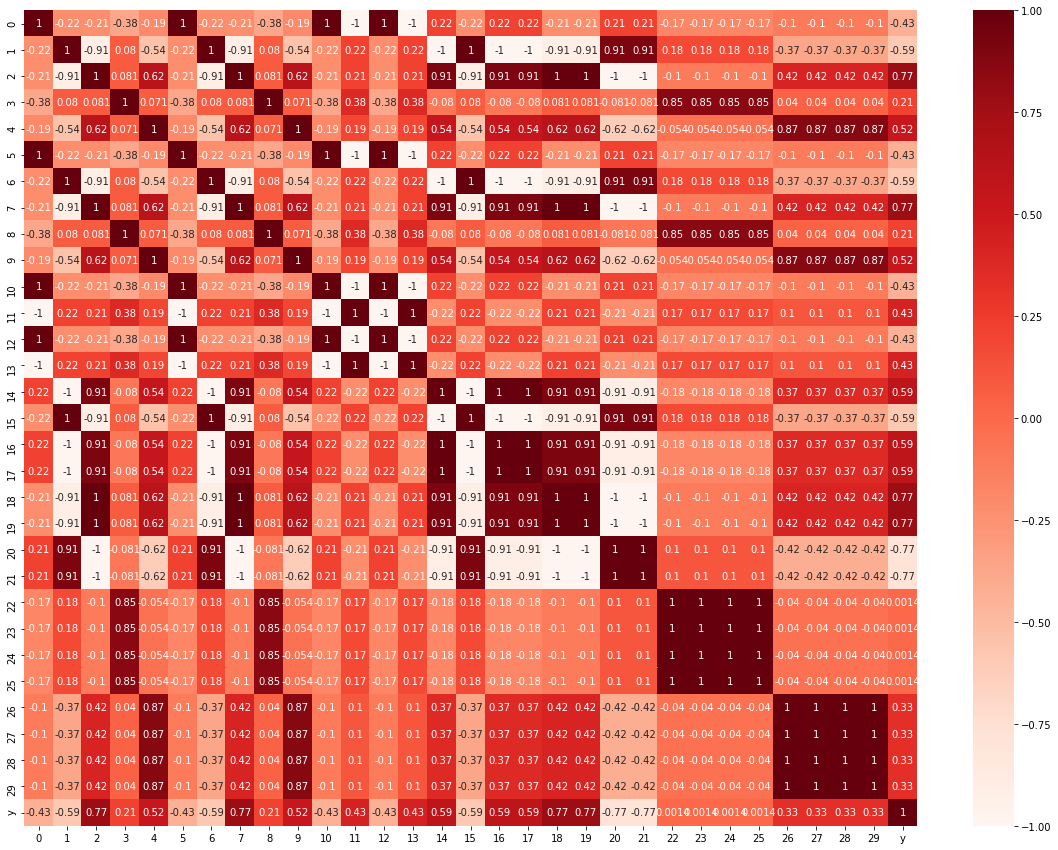

In [87]:
plt.figure(figsize=(20,15))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

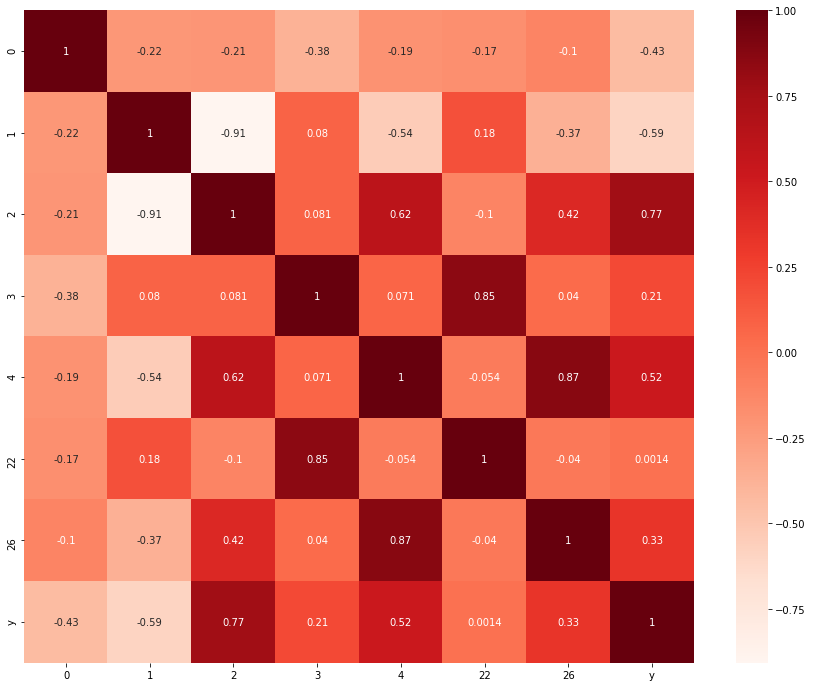

In [137]:
df1 = df.drop(columns=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,27,28,29])
dftest = dftest.drop(columns=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,23,24,25,27,28,29])
plt.figure(figsize=(15,12))
cor = df1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Посмотрим, есть ли в данных пропуски

In [89]:
print(df.shape)
print(df.dropna().shape)

(172744, 31)
(172744, 31)


Пропусков нет, а также произвели отбор кучи признаков, которые полностью коррелируют друг с другом.

In [138]:
name = 0
for column in df1.columns:
    if column =='y':
        continue
    df1.rename(columns={column:'c'+str(name)},inplace = True)
    dftest.rename(columns={column:'c'+str(name)},inplace = True)
    name+=1

In [91]:
df1.head()

,c0,c1,c2,c3,c4,c5,c6,y
0,0,0,1,2.288549,0.859431,6.467641,45.607623,0.658741
1,0,0,1,2.293655,-0.079660,6.500748,17.831804,0.671523
2,0,0,1,2.296195,1.243614,6.517282,66.970839,0.660211
3,0,0,1,2.296195,0.714635,6.517282,39.459637,0.662597
4,0,0,1,2.288549,0.422087,6.467641,29.451076,0.658827


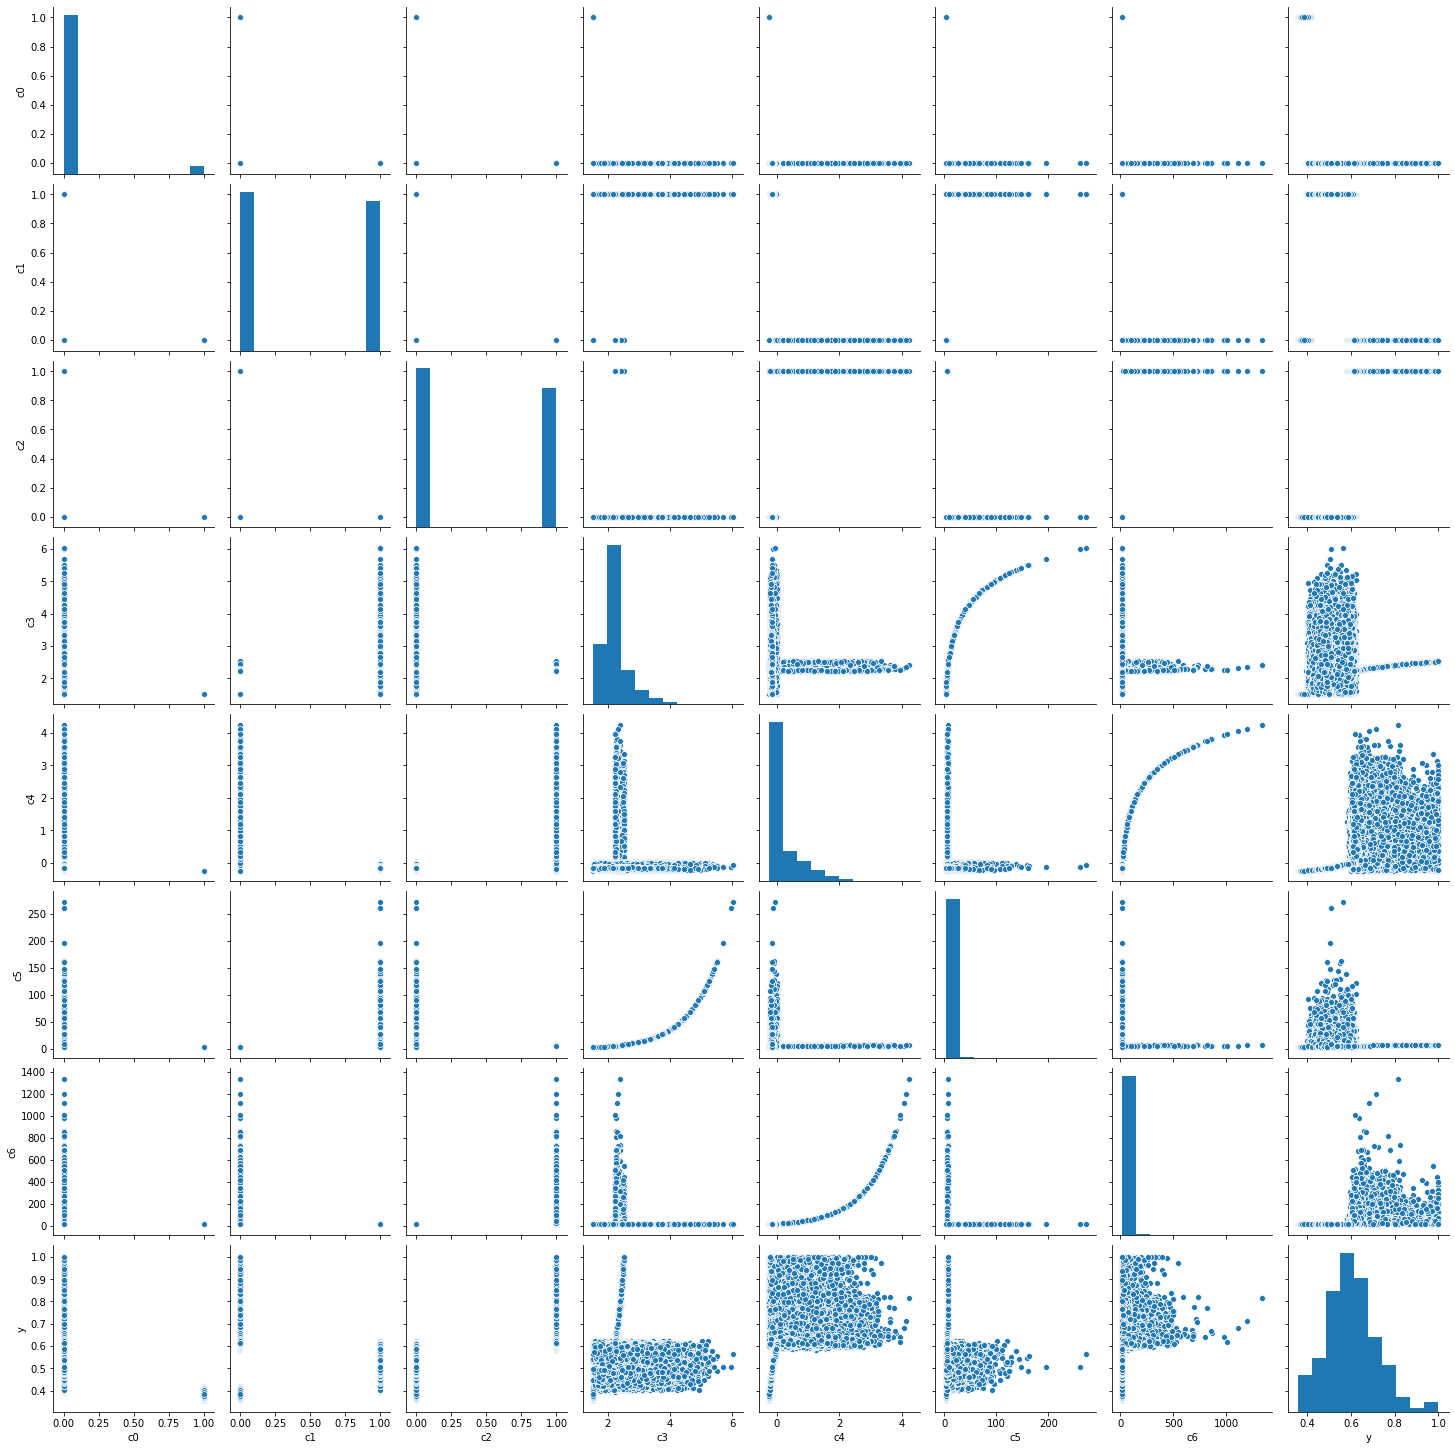

In [92]:
_ = sns.pairplot(df1)

Видно, что признаки 5 и 6 являются функциями от признаков 3 и 4, выкинем их, а также добавим межфакторное взаимодействие 3 и 4 признака

In [139]:
df1 = df1.drop(columns=['c5','c6'])
dftest = dftest.drop(columns=['c5','c6'])
req = 'y~'
for i in range(5):
    req = req + 'c'+str(i)+'+'
req = req[:-1]
req+='+c3:c4'
print(req)
model1 = sm.OLS.from_formula(req, df1).fit()
model1.summary()

y~c0+c1+c2+c3+c4+c3:c4


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                 9.339e+04
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        20:24:36   Log-Likelihood:             2.5153e+05
No. Observations:              172744   AIC:                        -5.031e+05
Df Residuals:                  172737   BIC:                        -5.030e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -4.05e+09   9.95e+09     -0.407      0.684   -2.36e+10    1.55e+10
c0           4.05e+09   9.95e+09      0.407      0.684   -1.55e+10    2.36e+10
c1           4.05e+09   9.95e+09      0.407      0.684   -1.55e+10    2.36e+10
c2           4.05e+09   9.95e+09      0.407      0.684   -1.55e+10    2.36e+10
c3             0.0714      0.000    181.067      0.000       0.071       0.072
c4            -1.6144      0.006   -249.002      0.000      -1.627      -1.602
c3:c4          0.6998      0.003    250.667      0.000       0.694       0.705
==============================================================================
Omnibus:                    32494.564   Durbin-Watson:                   0.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           106033.287
Skew:                           0.956   Prob(JB):                         0.00
Kurtosis:                       6.328   Cond. No.                     3.94e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.04e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

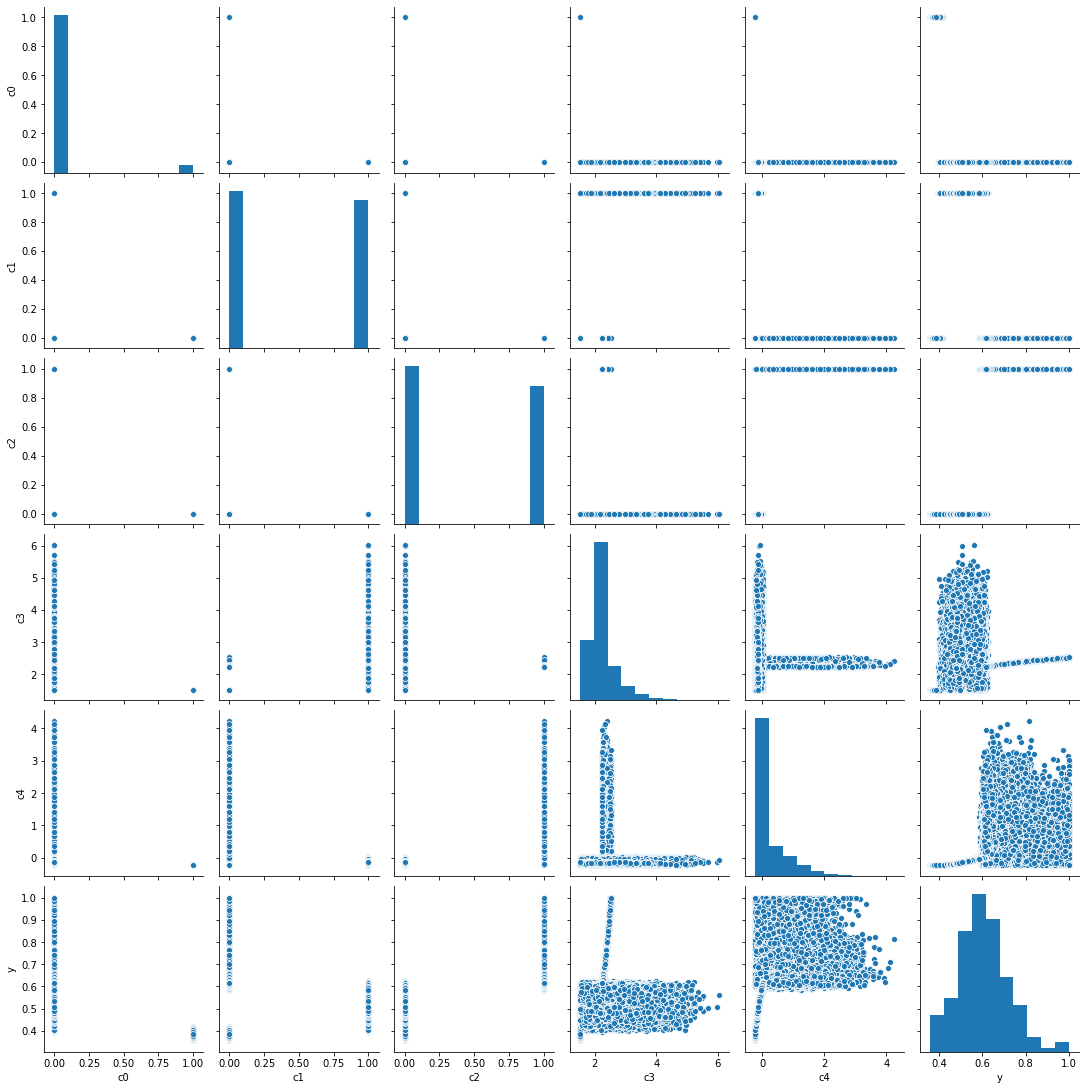

In [95]:
_ = sns.pairplot(df1)

И явно не лишним будет взаимодействие 2 и 3 признаков, а также 2 и 4

In [101]:
req = 'y~'
for i in range(5):
    req = req + 'c'+str(i)+'+'
req = req[:-1]
req+='+c3:c4+c3:c2+c4:c2'
print(req)
model1 = sm.OLS.from_formula(req, df1).fit()
model1.summary()

y~c0+c1+c2+c3+c4+c3:c4+c3:c2+c4:c2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 2.714e+06
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        19:33:28   Log-Likelihood:             5.4489e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172735   BIC:                        -1.090e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.944e+08   1.83e+09      0.216      0.829   -3.19e+09    3.98e+09
c0         -3.944e+08   1.83e+09     -0.216      0.829   -3.98e+09    3.19e+09
c1         -3.944e+08   1.83e+09     -0.216      0.829   -3.98e+09    3.19e+09
c2         -3.944e+08   1.83e+09     -0.216      0.829   -3.98e+09    3.19e+09
c3         -8.028e-05   8.27e-05     -0.971      0.331      -0.000    8.17e-05
c4             0.7543      0.002    472.825      0.000       0.751       0.757
c3:c4         -0.0011      0.001     -1.727      0.084      -0.002       0.000
c3:c2          1.2307      0.001   1782.915      0.000       1.229       1.232
c4:c2         -0.7516      0.001  -1342.698      0.000      -0.753      -0.751
==============================================================================
Omnibus:                    27253.721   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            91627.734
Skew:                           0.798   Prob(JB):                         0.00
Kurtosis:                       6.192   Cond. No.                     4.41e+14
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.97e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# превосходно!

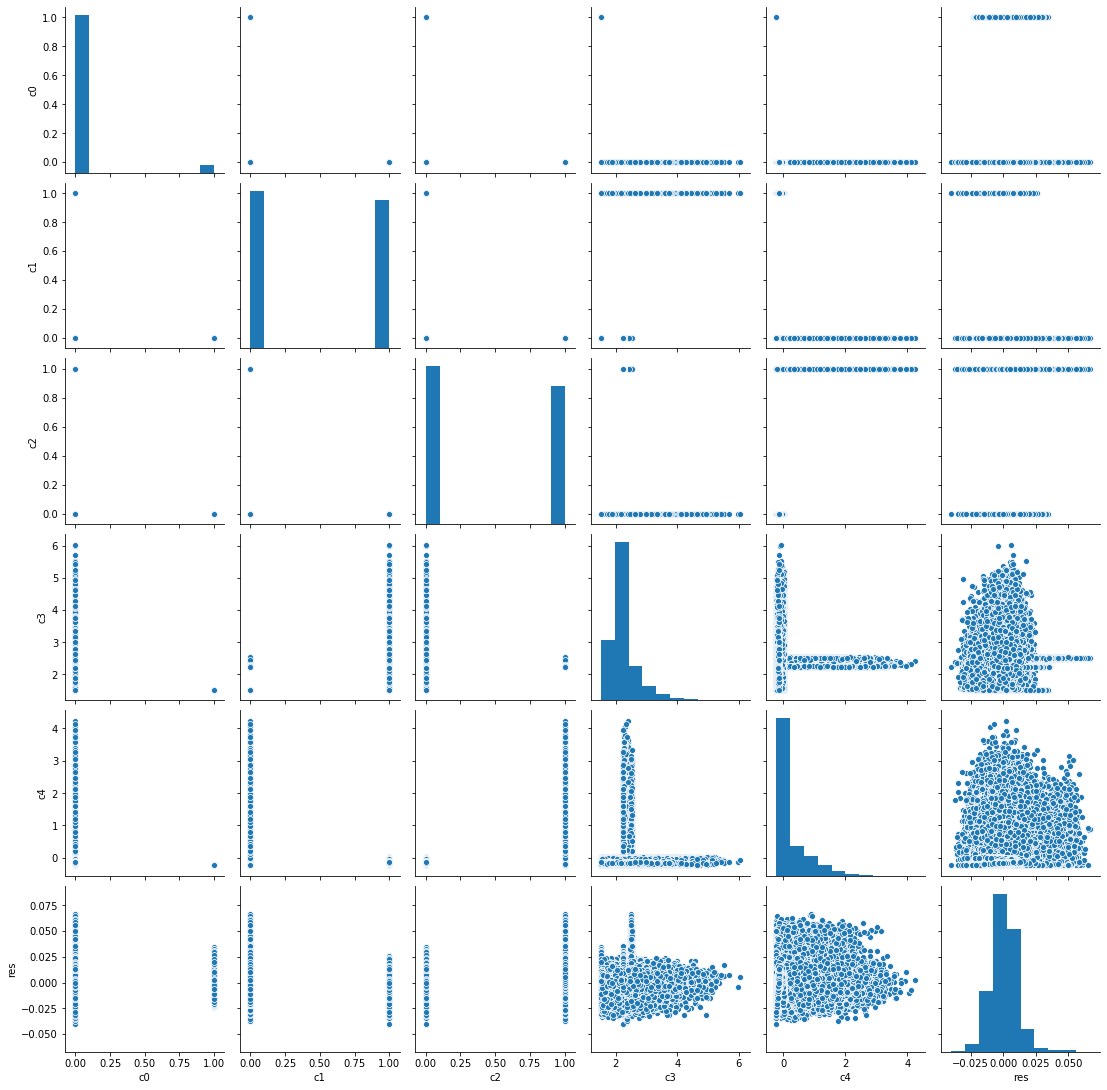

In [102]:
df1['res'] = model1.resid
_ = sns.pairplot(df1.drop(columns=['y']))

Ну собственно тут только шум и ничего больше, модель великолепна)

In [107]:
model1.params

Intercept    3.930571e+08
c0          -3.930571e+08
c1          -3.930571e+08
c2          -3.930571e+08
c4           7.532771e-01
c3:c4       -6.770596e-04
c3:c2        1.230363e+00
c4:c2       -7.516362e-01
dtype: float64

In [119]:
req = 'y~'
for i in [0,1,4]:
    req = req + 'c'+str(i)+'+'
req = req[:-1]
req+='+c3:c2+c4:c2'
print(req)
model1 = sm.OLS.from_formula(req, df1).fit()
model1.summary()

y~c0+c1+c4+c3:c2+c4:c2


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                 4.357e+06
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        19:48:26   Log-Likelihood:             5.4518e+05
No. Observations:              172744   AIC:                        -1.090e+06
Df Residuals:                  172738   BIC:                        -1.090e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1516      0.001  -1707.373      0.000      -2.154      -2.149
c0             2.7100      0.001   2130.675      0.000       2.708       2.713
c1             2.7531      0.001   2182.105      0.000       2.751       2.756
c4             0.7517      0.001   1352.975      0.000       0.751       0.753
c3:c2          1.2300      0.001   2265.569      0.000       1.229       1.231
c4:c2         -0.7516      0.001  -1344.965      0.000      -0.753      -0.751
==============================================================================
Omnibus:                    28509.510   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            97131.263
Skew:                           0.829   Prob(JB):                         0.00
Kurtosis:                       6.278   Cond. No.                         168.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Финально убрал признак c2, так как он итак выражается через 0 и 1 и убрал межфакторно 3 и 4

In [122]:
model1.params

Intercept   -2.151634
c0           2.710031
c1           2.753100
c4           0.751706
c3:c2        1.229981
c4:c2       -0.751635
dtype: float64

c0 и c1 обладают тем свойством, что если одно из них 1, то второе обязательно ноль. Фактически признаки c0,c1,c2 это 1, если y принадлежит определенному интервалу (за счет того, что вместе эти интервалы покрывают все множетсво значений y один из признаков оказывается избыточным)

c3 и c4 такие, что если y больше(или меньше) определнного значения, то распределение признака случайно из равномерного распределения, но если y лежит в другом диапазоне, то c3 и c4 принимают узкий набор значений.

Наконец получим изображение:

In [144]:
img_test = Image.fromarray((np.array(model.predict(dftest)).reshape((X_test.shape)[0],(X_test.shape)[1])*255).astype('uint8'))
img_test.save('my.png')
img_test.show()

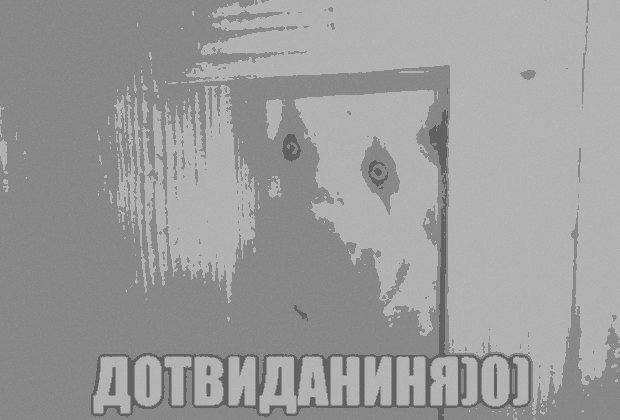

In [146]:
from IPython.display import Image
Image(filename='my.png')